In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [9]:
n = 200

centers = [2,4,6,8]
sigma = 0.4
k = len(centers)

np.random.seed(2021)

In [11]:
gt_label_indices = np.random.permutation(np.arange(n))
gt_label_indices

array([ 13,  87,   4,  37,  34,  41, 153,  70, 129,  52, 138,   0, 108,
       118, 146, 106,  35, 137, 192, 139, 147, 103, 140, 111, 124, 179,
        46, 121,  45, 105, 181, 130, 176, 136,  81,  64,  50,  29, 167,
       185, 126, 157, 133, 156,  83, 150, 162, 165,  15,  11, 184, 107,
        66,  95,  58, 159, 188,  43, 100, 198, 183, 180,  71,  22,  57,
        88,   1,   5, 191,  76, 149,  92, 113,  67,   6,  48, 158, 144,
        86,  28,  53,  25, 194,  36,  77, 151,  14, 168, 104,  38,  99,
        12,  31,  47,  42, 120,  30, 122,  90, 115, 134,  96,  54,  91,
        23,  89,  97,   9,   2, 169, 119, 112,  74,  55,  60,  51, 155,
        40,  69,  44,  84,  56,   8,  94,  63, 125, 154, 189, 196, 161,
       171, 143,  21,  16, 174, 195, 142, 186, 170,  72, 148,   7, 101,
        79, 177,  59, 145,  68, 116,  26, 187,  65, 164, 132,  20, 173,
        93, 102,  78, 190, 127, 109,  85, 141, 110,  32, 131, 152, 182,
        80,  33, 193,  73,   3,  19, 114, 172,  82, 178, 199, 16

In [13]:
gt_labels = np.repeat(np.arange(k), n//k)[gt_label_indices]
gt_labels

array([0, 1, 0, 0, 0, 0, 3, 1, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2,
       2, 2, 2, 3, 0, 2, 0, 2, 3, 2, 3, 2, 1, 1, 1, 0, 3, 3, 2, 3, 2, 3,
       1, 3, 3, 3, 0, 0, 3, 2, 1, 1, 1, 3, 3, 0, 2, 3, 3, 3, 1, 0, 1, 1,
       0, 0, 3, 1, 2, 1, 2, 1, 0, 0, 3, 2, 1, 0, 1, 0, 3, 0, 1, 3, 0, 3,
       2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 3,
       2, 2, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 0, 1, 1, 2, 3, 3, 3, 3, 3, 2,
       0, 0, 3, 3, 2, 3, 3, 1, 2, 0, 2, 1, 3, 1, 2, 1, 2, 0, 3, 1, 3, 2,
       0, 3, 1, 2, 1, 3, 2, 2, 1, 2, 2, 0, 2, 3, 3, 1, 0, 3, 1, 0, 0, 2,
       3, 1, 3, 3, 3, 3, 3, 2, 0, 0, 3, 0, 1, 3, 1, 0, 2, 2, 2, 1, 1, 0,
       0, 0])

In [43]:
cluster_data = np.stack([np.random.normal(loc=m, scale=sigma, size=n//k) for m in centers])
data.shape

(200,)

In [44]:
data = cluster_data.reshape(-1)[gt_label_indices]

#data

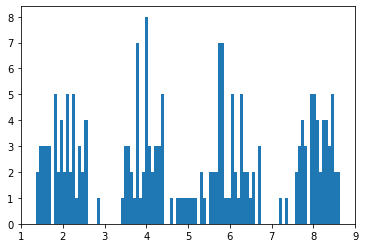

In [45]:
n_bins = n//2
_ = plt.hist(data, bins=n_bins)

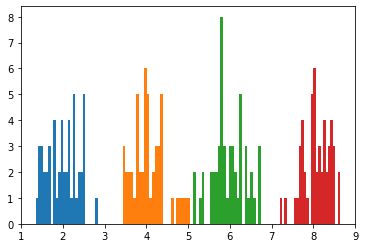

In [46]:
for i in range(k): 
    plt.hist(cluster_data[i], bins=n_bins//k)


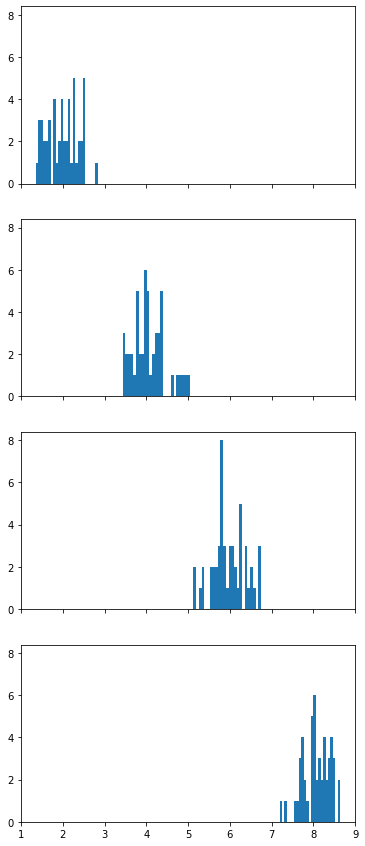

In [49]:
fig, axs = plt.subplots(k, sharex=True, sharey=True)
fig.set_figheight(15)

for i in range(k):
    axs[i].hist(cluster_data[i], bins=n_bins//k)

In [50]:
def epsilon_neighbor(d, eps=1.0):
    #neighbor_indices, _ = np.where(data < eps**2)
    #return neighbor_indices
    return (d < eps**2).astype(int)

def gauss_sim(d, sigma=1.0):
    #np.log(d)
    return np.exp(-d/sigma**2)

def getSimilarity(data, weighted=True):
    dist = np.square(data - np.tile(data, (data.shape[0],1)).T)
    if weighted:
        return gauss_sim(dist)
    else:
        return epsilon_neighbor(dist)

def getLaplacian(W):
    return np.diag(np.sum(W, axis=0)) - W

In [51]:
W = getSimilarity(data, weighted=False)
W.shape

(200, 200)

In [52]:
# TODO: Visualize sim graph

In [53]:
W

array([[1, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1]])

In [54]:
L = getLaplacian(W)
L.shape

(200, 200)

In [55]:
L

array([[48,  0, -1, ..., -1, -1, -1],
       [ 0, 47,  0, ...,  0,  0,  0],
       [-1,  0, 48, ..., -1, -1, -1],
       ...,
       [-1,  0, -1, ..., 49, -1, -1],
       [-1,  0, -1, ..., -1, 49, -1],
       [-1,  0, -1, ..., -1, -1, 48]])

In [64]:
lam, U = np.linalg.eigh(L)
#assert(np.all(np.argsort(lam) == np.arange(lam.shape[0])))
sorted_ind = np.argsort(lam)

num_ref = k #int(k*1.5)
smallest_ind = sorted_ind[:k+num_ref]
lam[smallest_ind]

array([-1.43388609e-16,  4.90301210e-01,  1.25021101e+00,  4.40692364e+00,
        3.56481499e+01,  3.71340360e+01,  4.00456810e+01,  4.18538951e+01])

In [65]:
smallest_ind

array([0, 1, 2, 3, 4, 5, 6, 7])

In [66]:
U[:,smallest_ind[:k]]
U_best = U[:,smallest_ind[:k]]

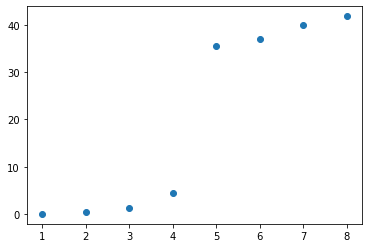

In [67]:
plt.scatter(np.arange(k+num_ref)+1, lam[smallest_ind])

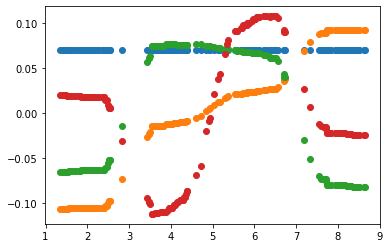

In [68]:
for i in range(k): 
    u = U_best[:,i]
    plt.scatter(data, u)

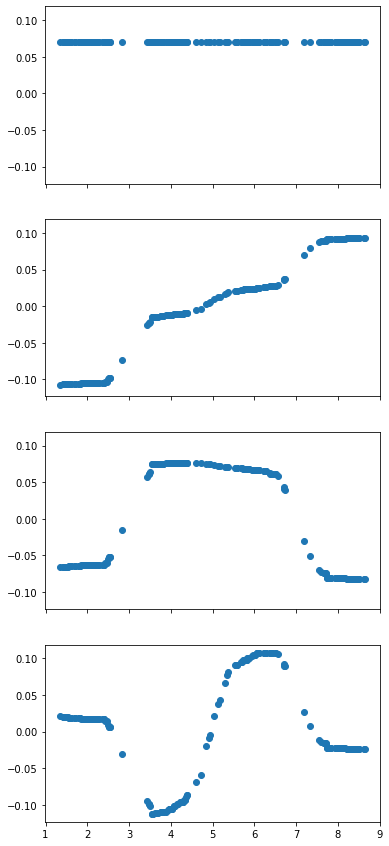

In [69]:
fig, axs = plt.subplots(k, sharex=True, sharey=True)
fig.set_figheight(15)

for i in range(k):
    u = U_best[:,i]
    #print(u)
    axs[i].scatter(data, u)

In [70]:
U_best[0]

array([ 0.07071068, -0.10356739, -0.0605816 ,  0.01490308])

In [71]:
kmeans = KMeans(n_clusters=k).fit(U_best)

In [72]:
def reorderLabels(labels):
    pred = []
    ordered_label = 0
    prev_labels = {}

    for c in labels:
        if c not in prev_labels:
            prev_labels[c] = ordered_label
            ordered_label += 1
        pred.append(prev_labels[c])

    return np.array(pred)

In [75]:
def spectral_clustering(data, k):
    W = getSimilarity(data, weighted=False)
    L = getLaplacian(W)
    
    lam, U = np.linalg.eigh(L)
    sorted_ind = np.argsort(lam)
    U_best = U[:, sorted_ind[:k]]
    
    kmeans = KMeans(n_clusters=k).fit(U_best)
    #pred_clusters = reorderLabels(kmeans.labels_)

    return kmeans.labels_

In [76]:
pred = spectral_clustering(data, k)

In [77]:
# TODO: change evaluation metric to distance measure
# Compare brute-force search for min distance
def getLoss(data, label, return_cluster_loss=False):
    all_loss = []
    for c in np.unique(label):
        #cluster_indices = np.where(c == pred)
        cluster_data = data[c == label]
        cluster_dist = np.square(cluster_data - np.tile(cluster_data, (cluster_data.shape[0],1)).T)
        cluster_loss = np.sum(cluster_dist)
        all_loss.append(cluster_loss)
    
    return sum(all_loss) if not return_cluster_loss else (sum(all_loss), all_loss)

In [78]:
getLoss(data, pred)

2733.257536185633

In [80]:
getLoss(data, gt_labels)

2743.1174301107676

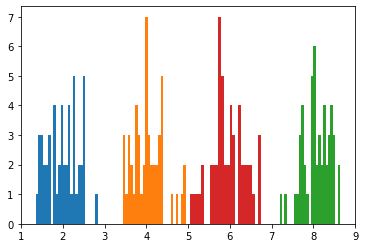

In [81]:
for c in np.unique(pred): 
    plt.hist(data[c==pred], bins=n_bins//k)

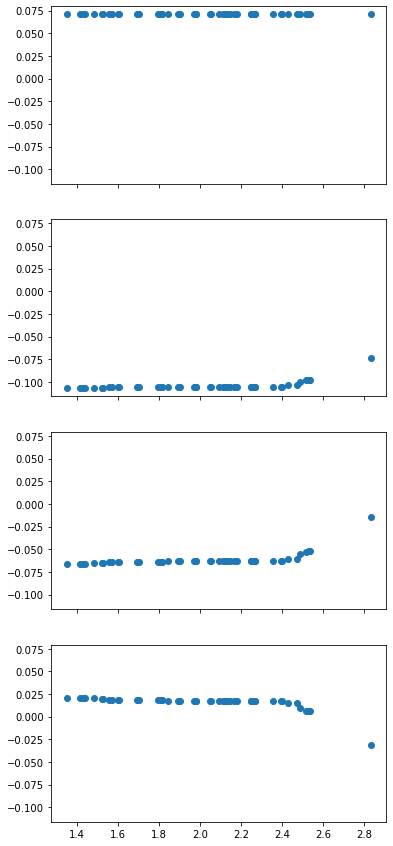

In [92]:
#i = 3
c = 0

fig, axs = plt.subplots(k, sharex=True, sharey=True)
fig.set_figheight(15)

for i in range(k):
    #u = U_best[:,i]
    axs[i].scatter(data[c==pred], U_best[c==pred, i])

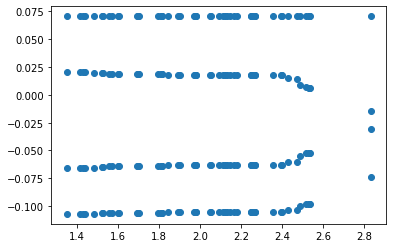

In [93]:
i = 3
c = 0

x = np.tile(data[c==pred], k)
y = np.concatenate([U_best[c==pred,i] for i in range(k)])
plt.scatter(x, y)

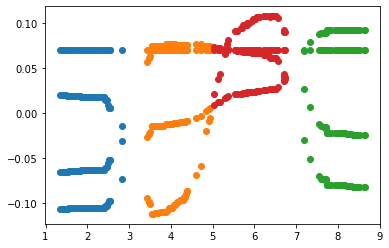

In [94]:
for c in np.unique(pred): 
    x = np.tile(data[c==pred], k)
    y = np.concatenate([U_best[c==pred,i] for i in range(k)])
    plt.scatter(x, y)

In [ ]:
for i in range(k): 
    u = U_best[:,i]
    plt.scatter(data, u)

In [ ]:
# TODO: Control Hyperparameter of getSim

In [ ]:
# TODO: Implement local scaling, add harder example, take time on big example